# Oct 14 collected sample

Michelle ran this sample.  spreadsheet

"BreslAu River Filtered Collected Oct 14.23.xlsx"

In [7]:
% housekeeping
% clear data and number format
clear; format short e
% turn off warnings
warning off
graphics_toolkit ("notebook"); 
%graphics_toolkit ("plotly"); 

In [8]:
% put in constants
VT=0.05; %total volume
stockPbconc=1000e-6; %M

In [9]:
% put in data

originalsamplemVnpH=[...
%pH mV
8.498  -147.1
8.503  -144.1
8.527  -144.7
];

calibdata=[...
%volPb mV pH
0 33.7 2.068
1 41 2.057
3 44.1 2.054
10 46.7 2.057
100 45.2 2.049
1000 186.4 1.468
];


pH = 8.5093e+00


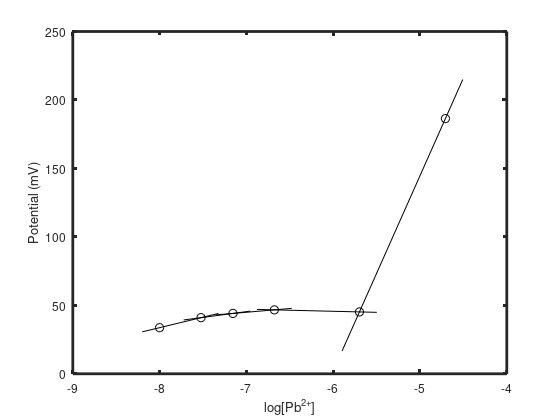

In [10]:
graphics_toolkit("notebook")
% pull out the sample data
pH=mean(originalsamplemVnpH(:,1))
mVoriginal=(originalsamplemVnpH(:,2));

%pull out the calibration data
addedPbvol=calibdata(:,1)'*1e-6; pHcalib=calibdata(:,3); mV=calibdata(:,2)'; 
PbTmeas=10e-9; % not actually known until it is measured 
PbT=PbTmeas; PbTplus=(PbTmeas*(VT)+addedPbvol*stockPbconc)./(VT+addedPbvol);

plot(log10(PbTplus),mV,'ko'); hold on

%chlorocorrecxtion
%BF1=2.49; BF2=1.14; BF3=0.9; ClT=4.9904e-4; %from Inorg. Chem. 1983. 22. 3323-3326.
%CuTplus=CuTplus./(1+BF1*ClT+BF2*ClT^2+BF3*ClT^3);

%determine all the slopes and intercepts for each pair of mV values
for i=1:length(mV)-1
    param=polyfit([log10(PbTplus(i)) log10(PbTplus(i+1))],[mV(i) mV(i+1)],1);
    val=polyval(param,[log10(PbTplus(i))-0.2 log10(PbTplus(i+1))+0.2]);
    plot([log10(PbTplus(i))-0.2 log10(PbTplus(i+1))+0.2],val,'k-')
    m(i)=param(1); Eo(i)=param(2); 
    %two ways to define what logCu is for the Eo and m values. need to pick the approach that consistently works best
    logPbT(i)=mean([log10(PbTplus(i)) log10(PbTplus(i+1))]); % calib Pb is the midpoint
    %logPbT(i)=[log10(PbTplus(i))]; % calib Pb is the starting point 
end
xlabel('log[Pb^{2+}]');  ylabel('mV');
set(gca,'fontsize',12); set(gca,'linewidth',2);
xlabel('log[Pb^{2+}]'); ylabel('Potential (mV)')

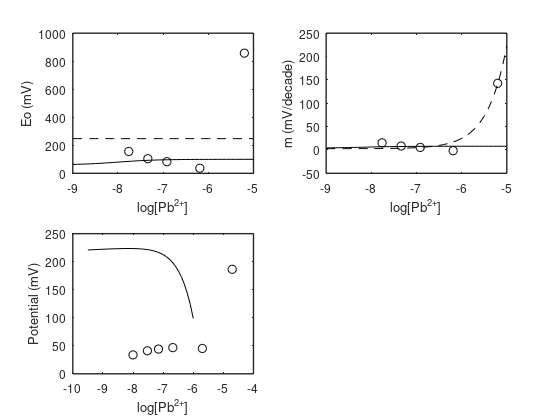

In [11]:
%plot and fit the s and Eo curves to a logit function.

subplot(221); plot(logPbT,Eo,'ko'); subplot(222); plot(logPbT,m,'ko');

%use logisticmodel
%define function
logisticfunction = @(p,logx) (p(1)+(p(2)-p(1))./(1+10.^(p(3)-logx)*p(4)));
errfunction=@(p,logx,meas) (log10(sum((meas-logisticfunction(p,logx)).^2)));

%fit Eo to meta calibration
ptst=[60 100 -8 1];
logx=-9:0.1:-5; model=logisticfunction(ptst,logx);
err=errfunction(ptst,logPbT,Eo);
subplot(221); hold on
plot(logx,model,'k-')
% now best fit
options = optimset('Display','off','TolFun',1e-4,'TolX',1e-4);
pbestEo=fminsearch(@(p) errfunction(p,logPbT,Eo),ptst,options);
model=logisticfunction(pbestEo,logx);
plot(logx,model,'k--')

%fit m to meta calibration
ptst=[4 8 -8 0.7];
logx=-9:0.1:-5; model=logisticfunction(ptst,logx);
err=errfunction(ptst,logPbT,m);
subplot(222); hold on
plot(logx,model,'k-')
% now best fit
options = optimset('Display','off','TolFun',1e-4,'TolX',1e-4);
pbestm=fminsearch(@(p) errfunction(p,logPbT,m),ptst,options);
model=logisticfunction(pbestm,logx);
plot(logx,model,'k--')

%plot the original data and the metacalibration fit
subplot(223)
plot(log10(PbTplus),mV,'ko'); hold on
logPbTplot=-9.5:0.1:-6; 
for i=1:length(logPbTplot)
    Eocalc=logisticfunction(pbestEo,logPbTplot(i));
    mcalc=logisticfunction(pbestm,logPbTplot(i));
    mVcalc(i)=Eocalc+mcalc*logPbTplot(i);
end
plot(logPbTplot,mVcalc,'k-')

subplot(221); set(gca,'fontsize',12); set(gca,'linewidth',1);
xlabel('log[Pb^{2+}]'); ylabel('Eo (mV)')
    
subplot(222); set(gca,'fontsize',12); set(gca,'linewidth',1);
xlabel('log[Pb^{2+}]'); ylabel('m (mV/decade)')

subplot(223); set(gca,'fontsize',12); set(gca,'linewidth',1);
xlabel('log[Pb^{2+}]'); ylabel('Potential (mV)')

Eooriginal = 2.4753e+02


moriginal = 3.0145e+00


logPboriginal,1
1,-130.909
2,-129.914
3,-130.113


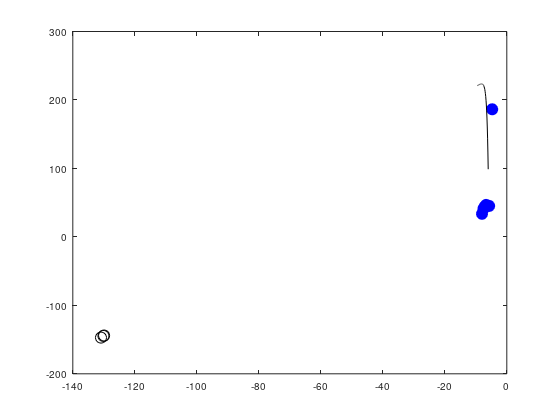

In [12]:
% then use this metacalibration to determine original sample logPb2+

Eooriginal=logisticfunction(pbestEo,log10(PbT))
moriginal=logisticfunction(pbestm,log10(PbT))

logPboriginal=(mVoriginal-Eooriginal)/moriginal

plot(log10(PbTplus),mV,'bo','markersize',8,'markerfacecolor','b'); hold on
plot(logPbTplot,mVcalc,'k-')
plot(logPboriginal,mVoriginal,'ko','markersize',8)